## Time-by-time decoding in sensor space

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import mne

mne.set_log_level(verbose='WARNING')


subjects = [
    '04', '06', '07','08', '09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 2', 'Cond == 4']


N_JOBS = 7


def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs

### What does the classifier need to operate?

We are going to perform "supervised" learning. For this, our classifiers, in essence, need two things:

1. the **data** containing the features the classifier should learn on
1. the corresponding **labels,** i.e., to which class (in our case: which experimental condition) the respective data belongs to.

In [2]:
epochs = read_cleaned_epochs('07')

metadata_query = f'{contrast[0]} or {contrast[1]}'
epochs_to_contrast = epochs[metadata_query]

# The data was Maxwell-filtered, so gradiometers and magnetometers are
# correlated and, therefore, practically contain the "same" information.
# We can therefore use magnetometers only, which will speed up processing
# as there's only 1/3rd of the number of sensors compared to gradiometers.
epochs_to_contrast.pick_types(meg='mag')

X = epochs_to_contrast.get_data()  # data
y = epochs_to_contrast.metadata['Cond']  # labels

print(X.shape)
print(y)

(459, 102, 44)
962     2
966     4
1009    4
1033    4
1034    4
       ..
6672    4
6677    4
6688    2
6711    4
6718    2
Name: Cond, Length: 459, dtype: int64


In [3]:
def get_epochs_to_contrast(epochs):
    metadata_query = f'{contrast[0]} or {contrast[1]}'
    epochs_to_contrast = epochs[metadata_query]

    # The data was Maxwell-filtered, so gradiometers and magnetometers are
    # correlated and, therefore, practically contain the "same" information.
    # We can therefore use magnetometers only, which will speed up processing
    # as there's only 1/3rd of the number of sensors compared to gradiometers.
    epochs_to_contrast.pick_types(meg='mag')

    return epochs_to_contrast

In [4]:
from pqdm.processes import pqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.decoding import SlidingEstimator, cross_val_multiscore


classification_pipeline = make_pipeline(
    StandardScaler(),  # normalize the data
    LogisticRegression(solver='liblinear')
)

# The sliding-window estimator runs our clasfficiation pipeline at each
# time point independently.
time_decoding_estimator = SlidingEstimator(
    classification_pipeline,
    scoring='roc_auc',
    n_jobs=N_JOBS  # Go parallel across time points
)

def time_by_time_decoding(subject):
    # Prepare the data
    epochs = read_cleaned_epochs(subject)
    epochs_to_contrast = get_epochs_to_contrast(epochs)
    X = epochs_to_contrast.get_data()  # data
    y = epochs_to_contrast.metadata['Cond']  # labels

    # Now, actually run the classification, and evaluate it via a cross-validation
    # procedure.
    scores = cross_val_multiscore(
        estimator=time_decoding_estimator,
        X=X,
        y=y,
        cv=5,
        n_jobs=1
    )
    return scores


decoding_scores_all_subjects = pqdm(
    subjects, time_by_time_decoding, n_jobs=1
)

  0%|          | 0/23 [00:00<?, ?it/s]

In [5]:
len(decoding_scores_all_subjects)

23

In [6]:
decoding_scores_all_subjects_mean = np.mean(decoding_scores_all_subjects, axis=1)
decoding_scores_all_subjects_mean.shape

(23, 44)

### Visualize decoding performance over time

#### Single participant

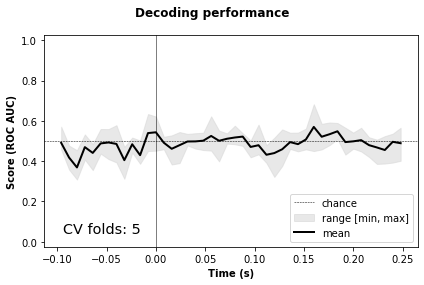

In [7]:
subject = '07'

# Read the time points from the epochs so we can use them to label the x axis
epochs = read_cleaned_epochs(subject)
times = epochs.times
del epochs

subject_idx = subjects.index(subject)

mean_scores = decoding_scores_all_subjects[subject_idx].mean(axis=0)
max_scores = decoding_scores_all_subjects[subject_idx].max(axis=0)
min_scores = decoding_scores_all_subjects[subject_idx].min(axis=0)

fig, ax = plt.subplots()
ax.axvline(0, ls='-', lw=0.5, color='black')
ax.axhline(0.5, ls='--', lw=0.5, color='black', label='chance')
ax.fill_between(
        x=times, y1=min_scores, y2=max_scores, color='lightgray',
        alpha=0.5, label='range [min, max]'
)
ax.plot(times, mean_scores, ls='-', lw=2, color='black',
        label='mean')

ax.text(0.05, 0.05,
        s=f'CV folds: {len(decoding_scores_all_subjects[subject_idx])}',
        fontsize='x-large', horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes
)

fig.suptitle('Decoding performance', fontweight='bold')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel(f'Score (ROC AUC)', fontweight='bold')
ax.set_ylim((-0.025, 1.025))
ax.legend(loc='lower right')
fig.tight_layout()

#### Grand average

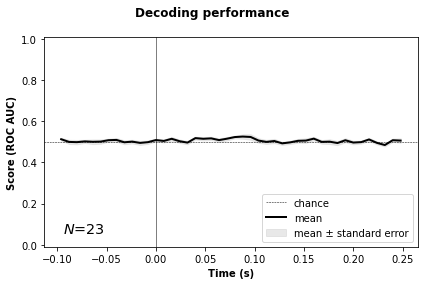

In [8]:
from scipy.stats import sem

# Just read the times from a random subject's epochs
subject = '07'
epochs = read_cleaned_epochs(subject)
times = epochs.times
del epochs

decoding_scores_all_subjects_mean = np.mean(decoding_scores_all_subjects, axis=1)

mean_scores = decoding_scores_all_subjects_mean.mean(axis=0)
se = sem(decoding_scores_all_subjects_mean)
se_lower = mean_scores - se
se_upper = mean_scores + se

fig, ax = plt.subplots()
ax.axhline(0.5, ls='--', lw=0.5, color='black', label='chance')
ax.axvline(0, ls='-', lw=0.5, color='black')
ax.plot(times, mean_scores, ls='-', lw=2, color='black',
        label='mean')
ax.fill_between(x=times, y1=se_lower, y2=se_upper, color='lightgray',
                alpha=0.5, label='mean ± standard error')

ax.text(0.05, 0.05, s=f'$N$={len(decoding_scores_all_subjects_mean)}',
        fontsize='x-large', horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

fig.suptitle('Decoding performance', fontweight='bold')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel(f'Score (ROC AUC)', fontweight='bold')
ax.set_ylim((-0.01, 1.01))
# ax.set_ylim((0.4, .6))
ax.legend(loc='lower right')
fig.tight_layout()

### Extracting the spatial patterns used by the classifiers

To do so, we
- we wrap the `LogisticRegression` object by a `LinearModel`, 
- re-fit the classifier on **all** data (i.e., no cross-validation or train-test splits)

We can then extract and visualize the spatial patterns that were used by the classifier to tell the two conditions apart.

In [10]:
from mne import EvokedArray
from mne.decoding import LinearModel, get_coef


classification_pipeline = make_pipeline(
    StandardScaler(),
    LinearModel( 
        LogisticRegression(solver='liblinear')
    )
)

time_decoding_estimator = SlidingEstimator(
    classification_pipeline,
    scoring='roc_auc',
    n_jobs=N_JOBS  # Go parallel across time points
)

def train_classifiers_and_extract_patterns(subject):
    # Prepare the data
    epochs = read_cleaned_epochs(subject)
    epochs_to_contrast = get_epochs_to_contrast(epochs)
    X = epochs_to_contrast.get_data()  # data
    y = epochs_to_contrast.metadata['Cond']  # labels

    # Fit the classifier on all data
    time_decoding_estimator.fit(X=X, y=y)

    # Extract the patterns
    patterns = get_coef(
        estimator=time_decoding_estimator,
        attr='patterns_',
        inverse_transform=True  # go "backwards" from decoding filter to sensor space
    )

    # Create a "fake" Evoked object from the patterns so we can visualize them
    evoked_patterns = EvokedArray(
        data=patterns,
        info=epochs_to_contrast.info,
        tmin=epochs_to_contrast.tmin
    )

    return evoked_patterns


classification_patterns = pqdm(
    subjects, train_classifiers_and_extract_patterns, n_jobs=1
)

  0%|          | 0/23 [00:00<?, ?it/s]

#### Visualizing the spatial patterns

##### Single subject

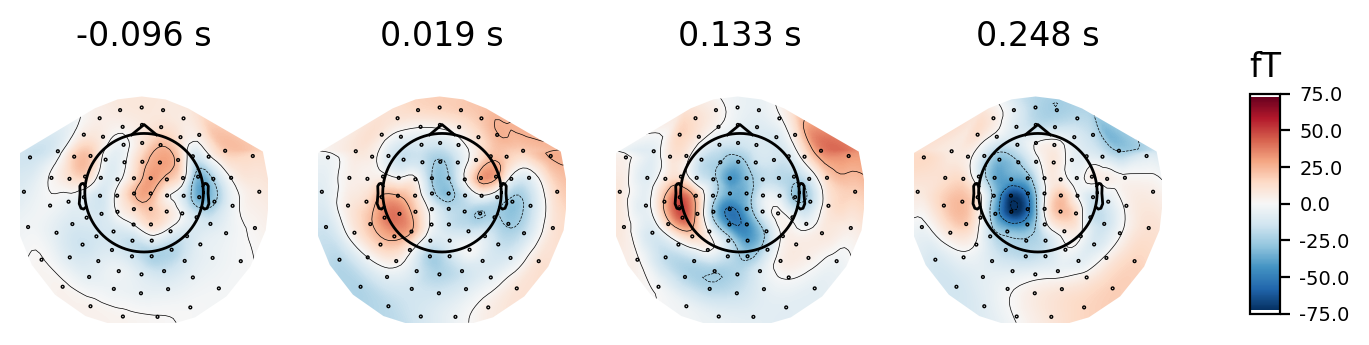

In [25]:
subject = '07'
subject_idx = subjects.index(subject)

patterns = classification_patterns[subject_idx]
patterns.plot_topomap()

In [24]:
%matplotlib qt

patterns.animate_topomap(
    frame_rate=5,
    times=patterns.times
)

(<Figure size 1200x1000 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x19211b6d0>)

##### Grand average

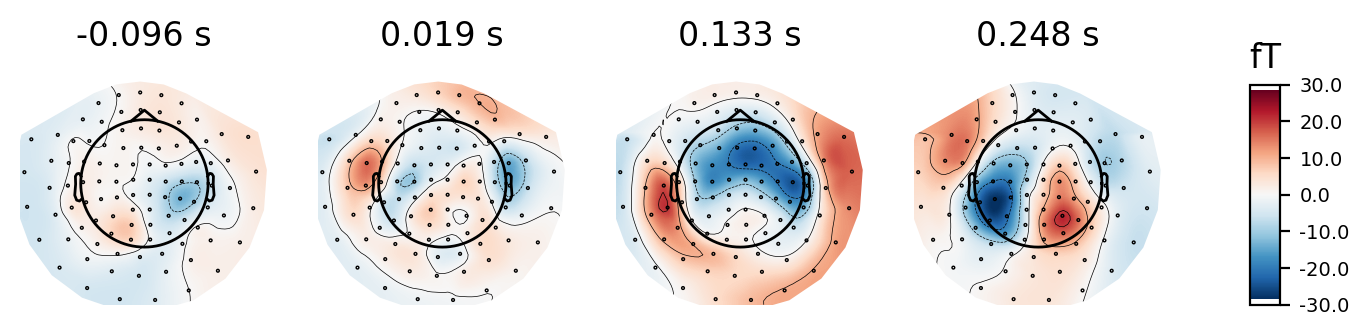

In [27]:
grand_average_patterns = mne.grand_average(classification_patterns)
grand_average_patterns.plot_topomap()

In [29]:
grand_average_patterns.animate_topomap(
    frame_rate=5,
    times=grand_average_patterns.times
)

(<Figure size 1200x1000 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x195c63370>)